# VADER

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as stat

In [21]:
merged_df=pd.read_csv('final_vader.csv')

In [10]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8662 entries, 0 to 8661
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ticker_symbol             8662 non-null   object 
 1   day_date                  8662 non-null   object 
 2   stock_performance         8662 non-null   object 
 3   prev_avg_sentiment_score  8662 non-null   float64
dtypes: float64(1), object(3)
memory usage: 270.8+ KB


In [4]:
df.head()

,ticker_symbol,day_date,stock_performance,prev_avg_sentiment_score
0,AAPL,2015-01-02,decline,0.134369
1,AAPL,2015-01-05,decline,0.206588
2,AAPL,2015-01-06,growth,0.128866
3,AAPL,2015-01-07,growth,0.148750
4,AAPL,2015-01-08,growth,0.145871


In [5]:
print(df[df['stock_performance']=='decline'].shape[0])
print(df[df['stock_performance']=='growth'].shape[0])

4308
4354


Null Hypothesis (H0): There is no significant difference in the average sentiment scores between growth and decline days.
Alternative Hypothesis (H1): There is a significant difference in the average sentiment scores between growth and decline days.

### checking assumptions for independent samples t test

1. Independence of Observations:  My primary goal is to understand the general relationship between sentiment and stock performance rather than model precise time-dependent effects, therefore, assuming independence for simplification.

2. Normality: The distribution of sentiment scores in each group should be approximately normal. This is less of a concern with large sample sizes (like 4354 and 4308).

In [12]:
from scipy.stats import shapiro, kstest, anderson, normaltest
import statsmodels.api as sm

/Users/susanoo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/susanoo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


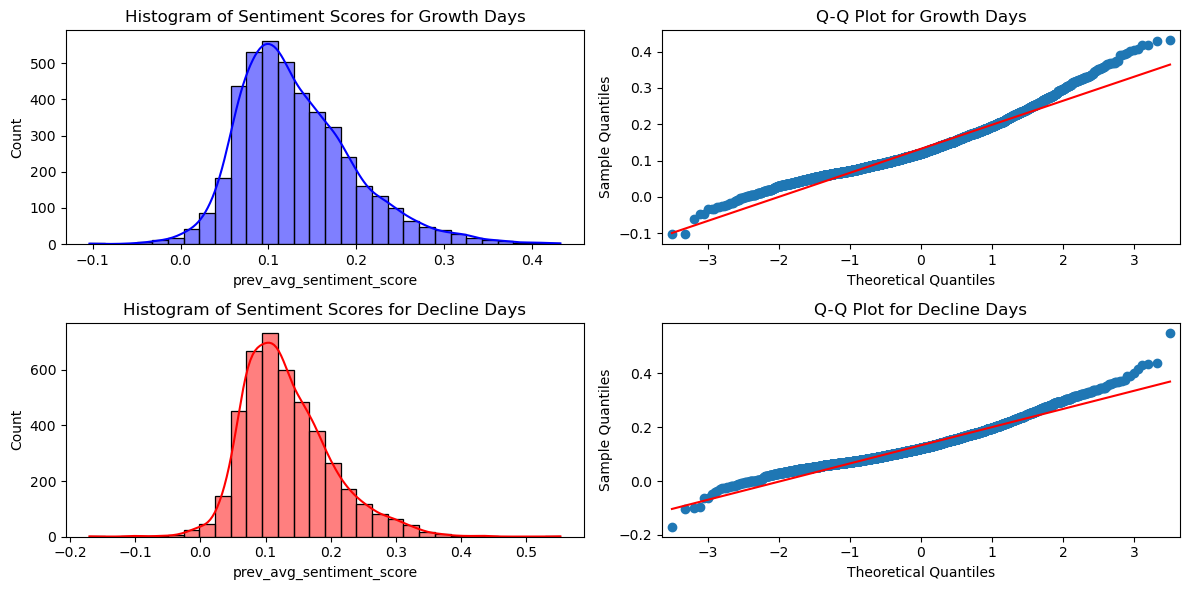

Shapiro-Wilk Test for Growth Days: W=0.9594954252243042, p-value=3.198456578424103e-33
Shapiro-Wilk Test for Decline Days: W=0.9608890414237976, p-value=1.3508332922428477e-32
Anderson-Darling Test for Growth Days: Statistic=47.598981202721006, Critical Values=[0.575 0.655 0.786 0.917 1.091]
Anderson-Darling Test for Decline Days: Statistic=46.871328999080106, Critical Values=[0.575 0.655 0.786 0.917 1.091]
D'Agostino and Pearson's Test for Growth Days: Statistic=505.196298980628, p-value=1.9861751201087412e-110
D'Agostino and Pearson's Test for Decline Days: Statistic=479.81242600307434, p-value=6.457367731412001e-105


In [22]:
#checking normality assumption

# Split the DataFrame into two groups: growth and decline
growth_days = merged_df[merged_df['stock_performance'] == 'growth']['prev_avg_sentiment_score']
decline_days = merged_df[merged_df['stock_performance'] == 'decline']['prev_avg_sentiment_score']

# Visual Inspection with Histogram and Q-Q Plot
plt.figure(figsize=(12, 6))

# Histogram for Growth Days
plt.subplot(2, 2, 1)
sns.histplot(growth_days, kde=True, color='blue', bins=30)
plt.title('Histogram of Sentiment Scores for Growth Days')

# Q-Q Plot for Growth Days
plt.subplot(2, 2, 2)
sm.qqplot(growth_days, line='s', ax=plt.gca())
plt.title('Q-Q Plot for Growth Days')

# Histogram for Decline Days
plt.subplot(2, 2, 3)
sns.histplot(decline_days, kde=True, color='red', bins=30)
plt.title('Histogram of Sentiment Scores for Decline Days')

# Q-Q Plot for Decline Days
plt.subplot(2, 2, 4)
sm.qqplot(decline_days, line='s', ax=plt.gca())
plt.title('Q-Q Plot for Decline Days')

plt.tight_layout()
plt.show()

# Shapiro-Wilk Test for Normality
shapiro_growth = shapiro(growth_days)
shapiro_decline = shapiro(decline_days)

print(f"Shapiro-Wilk Test for Growth Days: W={shapiro_growth[0]}, p-value={shapiro_growth[1]}")
print(f"Shapiro-Wilk Test for Decline Days: W={shapiro_decline[0]}, p-value={shapiro_decline[1]}")

# Additional Normality Tests (Optional)

# Anderson-Darling Test
anderson_growth = anderson(growth_days)
anderson_decline = anderson(decline_days)

print(f"Anderson-Darling Test for Growth Days: Statistic={anderson_growth.statistic}, Critical Values={anderson_growth.critical_values}")
print(f"Anderson-Darling Test for Decline Days: Statistic={anderson_decline.statistic}, Critical Values={anderson_decline.critical_values}")

# D'Agostino and Pearson's Test
normaltest_growth = normaltest(growth_days)
normaltest_decline = normaltest(decline_days)

print(f"D'Agostino and Pearson's Test for Growth Days: Statistic={normaltest_growth[0]}, p-value={normaltest_growth[1]}")
print(f"D'Agostino and Pearson's Test for Decline Days: Statistic={normaltest_decline[0]}, p-value={normaltest_decline[1]}")


Data appears to be normally distributed based on graphs

3. Equal Variances: The variances of sentiment scores in both groups should be roughly equal. If this assumption is violated, we can use Welch's t-test, which does not assume equal variances.

In [15]:
# Levene's Test

from scipy.stats import levene

# Perform Levene's Test for equal variances
stat, p_value = levene(growth_days, decline_days)

print(f"Levene's Test Statistic: {stat}, P-Value: {p_value}")

# Interpretation of Results
if p_value < 0.05:
    print("Reject the null hypothesis: The variances are not equal between growth and decline days.")
else:
    print("Fail to reject the null hypothesis: The variances are equal between growth and decline days.")


Levene's Test Statistic: 1.0291202807864117, P-Value: 0.31039371929285225
Fail to reject the null hypothesis: The variances are equal between growth and decline days.


### Conducting the independent samples T-Test with Equal Variances:

In [16]:
import pandas as pd
from scipy.stats import ttest_ind

# Assuming your merged DataFrame is named 'merged_df' and contains the columns:
# ['ticker_symbol', 'day_date', 'stock_performance', 'prev_avg_sentiment_score']

# Step 1: Split the DataFrame into two groups: growth and decline
growth_days = merged_df[merged_df['stock_performance'] == 'growth']['prev_avg_sentiment_score']
decline_days = merged_df[merged_df['stock_performance'] == 'decline']['prev_avg_sentiment_score']

# Step 2: Perform the Independent Samples T-Test with equal variances
t_stat, p_value = ttest_ind(growth_days, decline_days, equal_var=True)

print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

# Step 3: Interpretation of Results
if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference in sentiment scores between growth and decline days.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in sentiment scores between growth and decline days.")


T-Statistic: -0.6053065550775533, P-Value: 0.5449911882174854
Fail to reject the null hypothesis: There is no significant difference in sentiment scores between growth and decline days.


# BERT

In [23]:
merged_df=pd.read_csv('final_bert.csv')

In [18]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8662 entries, 0 to 8661
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ticker_symbol             8662 non-null   object 
 1   day_date                  8662 non-null   object 
 2   stock_performance         8662 non-null   object 
 3   prev_avg_sentiment_score  8662 non-null   float64
dtypes: float64(1), object(3)
memory usage: 270.8+ KB


In [19]:
print(df[df['stock_performance']=='decline'].shape[0])
print(df[df['stock_performance']=='growth'].shape[0])

4308
4354


### checking assumptions for independent samples t test

1. Independence of Observations: Assumed

2. Normality

/Users/susanoo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/susanoo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


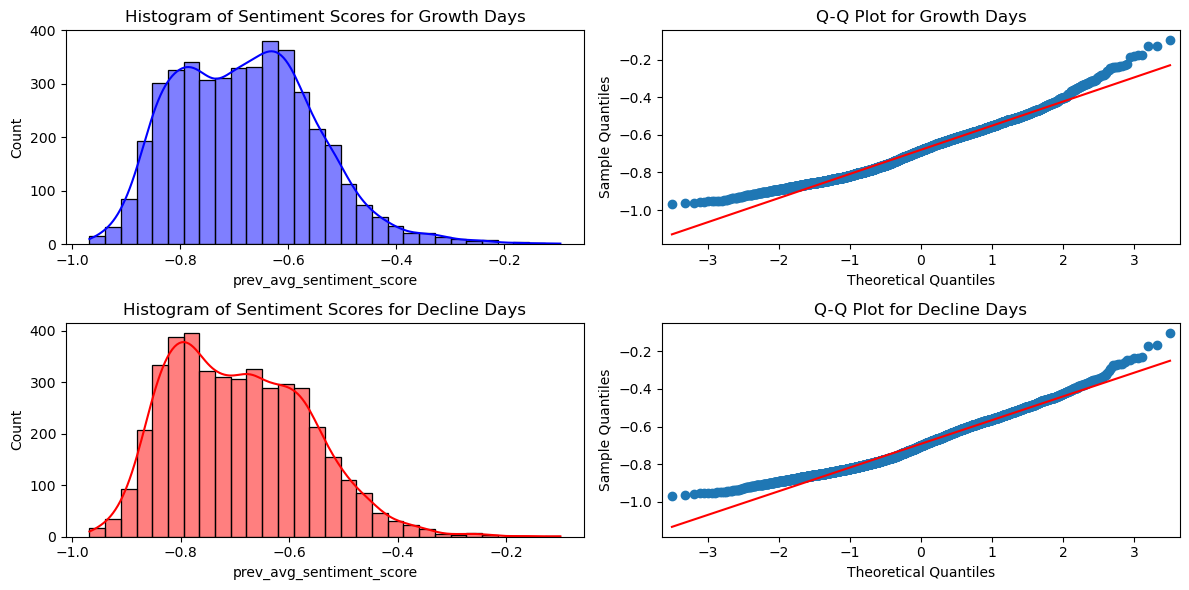

Shapiro-Wilk Test for Growth Days: W=0.9816139936447144, p-value=2.3503184548357317e-23
Shapiro-Wilk Test for Decline Days: W=0.9778002500534058, p-value=2.050817226002136e-25
Anderson-Darling Test for Growth Days: Statistic=13.746545477149084, Critical Values=[0.575 0.655 0.786 0.917 1.091]
Anderson-Darling Test for Decline Days: Statistic=24.416542814014974, Critical Values=[0.575 0.655 0.786 0.917 1.091]
D'Agostino and Pearson's Test for Growth Days: Statistic=152.79476594022495, p-value=6.622746689547303e-34
D'Agostino and Pearson's Test for Decline Days: Statistic=148.63594982217688, p-value=5.2980199568893714e-33


In [24]:
#checking normality assumption

# Split the DataFrame into two groups: growth and decline
growth_days = merged_df[merged_df['stock_performance'] == 'growth']['prev_avg_sentiment_score']
decline_days = merged_df[merged_df['stock_performance'] == 'decline']['prev_avg_sentiment_score']

# Visual Inspection with Histogram and Q-Q Plot
plt.figure(figsize=(12, 6))

# Histogram for Growth Days
plt.subplot(2, 2, 1)
sns.histplot(growth_days, kde=True, color='blue', bins=30)
plt.title('Histogram of Sentiment Scores for Growth Days')

# Q-Q Plot for Growth Days
plt.subplot(2, 2, 2)
sm.qqplot(growth_days, line='s', ax=plt.gca())
plt.title('Q-Q Plot for Growth Days')

# Histogram for Decline Days
plt.subplot(2, 2, 3)
sns.histplot(decline_days, kde=True, color='red', bins=30)
plt.title('Histogram of Sentiment Scores for Decline Days')

# Q-Q Plot for Decline Days
plt.subplot(2, 2, 4)
sm.qqplot(decline_days, line='s', ax=plt.gca())
plt.title('Q-Q Plot for Decline Days')

plt.tight_layout()
plt.show()

# Shapiro-Wilk Test for Normality
shapiro_growth = shapiro(growth_days)
shapiro_decline = shapiro(decline_days)

print(f"Shapiro-Wilk Test for Growth Days: W={shapiro_growth[0]}, p-value={shapiro_growth[1]}")
print(f"Shapiro-Wilk Test for Decline Days: W={shapiro_decline[0]}, p-value={shapiro_decline[1]}")

# Additional Normality Tests (Optional)

# Anderson-Darling Test
anderson_growth = anderson(growth_days)
anderson_decline = anderson(decline_days)

print(f"Anderson-Darling Test for Growth Days: Statistic={anderson_growth.statistic}, Critical Values={anderson_growth.critical_values}")
print(f"Anderson-Darling Test for Decline Days: Statistic={anderson_decline.statistic}, Critical Values={anderson_decline.critical_values}")

# D'Agostino and Pearson's Test
normaltest_growth = normaltest(growth_days)
normaltest_decline = normaltest(decline_days)

print(f"D'Agostino and Pearson's Test for Growth Days: Statistic={normaltest_growth[0]}, p-value={normaltest_growth[1]}")
print(f"D'Agostino and Pearson's Test for Decline Days: Statistic={normaltest_decline[0]}, p-value={normaltest_decline[1]}")


**Conclusion:**

The sentiment scores (as measured by BERT) for both growth and decline days are not normally distributed. This violates the normality assumption required for a standard independent samples t-test.

Therefore, we use a non parametric test called **Mann-Whitney U Test**

### Mann-Whitney U Test

In [25]:
from scipy.stats import mannwhitneyu

# Split the DataFrame into two groups: growth and decline
growth_days = merged_df[merged_df['stock_performance'] == 'growth']['prev_avg_sentiment_score']
decline_days = merged_df[merged_df['stock_performance'] == 'decline']['prev_avg_sentiment_score']

# Perform the Mann-Whitney U Test
u_stat, p_value = mannwhitneyu(growth_days, decline_days, alternative='two-sided')

print(f"U-Statistic: {u_stat}, P-Value: {p_value}")

# Interpretation of Results
if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference in sentiment scores between growth and decline days.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in sentiment scores between growth and decline days.")


U-Statistic: 9911476.0, P-Value: 4.6490232385818325e-06
Reject the null hypothesis: There is a significant difference in sentiment scores between growth and decline days.
